In [1]:
%matplotlib inline

# Volumetric Registration and Analysis
In this tutorial we align a Rat brain to the Waxholm.  Thus the Waxholm is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [2]:
from ndreg import *
import matplotlib
import ndio.remote.neurodata as neurodata

First we set the server and the user token from that server

In [3]:
server = "dev.neurodata.io"
userToken = txtRead("../userToken.pem").strip()

Now we download the atlas image

In [4]:
refToken = "whs2"
refImg = imgDownload(refToken, server=server, userToken=userToken)
refImgOrig = refImg[:,:,:]

Next we'll visuaize the image.  To ensure that the visuization is has good contrast we'll only show intensity values below the 99th percentile.

In [5]:
refThreshold = imgPercentile(refImg, 0.99)
print(refThreshold)

18379.0509804


When given an image volume *imgShow* displays it as a set of evenly spaced z-slices (1st column), y-slices (2nd column) and x slices (3rd column).

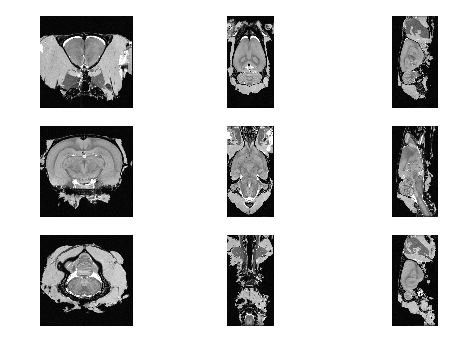

In [6]:
imgShow(refImg, vmax=refThreshold)

Now we download the corresponding annotations

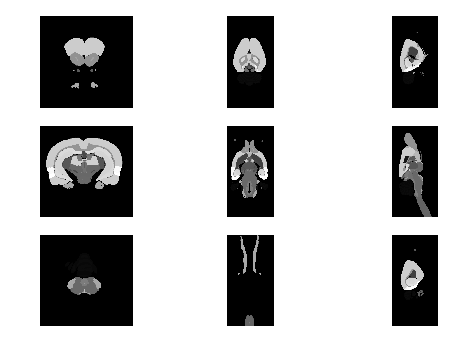

In [7]:
refAnnoImg = imgDownload(refToken, channel="annotation", server=server, userToken=userToken)
refAnnoImgOrig = refAnnoImg[:,:,:]
imgShow(refAnnoImg)

It's usually better to visuaize a set of annotations in color.  Let's display the atlas annotations using a random colormap.  We begin by creating a 1000x3 array of random values. Since we always want the backgrond (label 0) to be dark we make the 0th row is [0,0,0].

In [8]:
randValues = np.random.rand(1000,3)
randValues = np.concatenate(([[0,0,0]],randValues))

Now we can display the annotations.

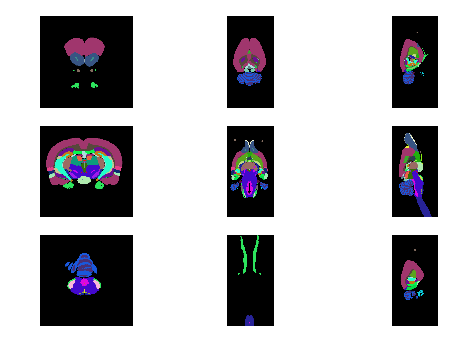

In [9]:
randCmap = matplotlib.colors.ListedColormap (randValues)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

Let's overlay these annotations on the atlas image using alpha transparency.  To do this we must set *newFig* to *False* so that matplotlib appends the annotation data to the current figure instead of creating new one.  

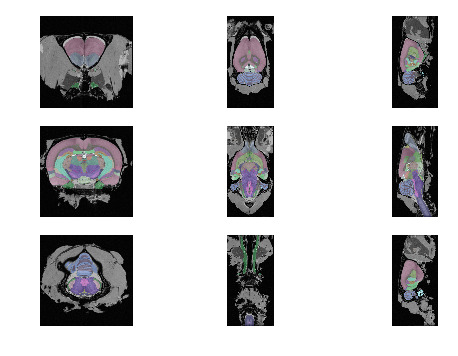

In [10]:
imgShow(refImg, vmax=refThreshold, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.3, newFig=False)
plt.show()

## Downloading input image
*ndstore* stores the brains at multiple resolutions. Resolution 0 is always the highest resolution each subsequent resoltion takes up 1/4th (under slice scaling) or 1/8th (under isotropic scaling) as many bytes as the previous resoltion.  We can use ndio's get_metadata method to see a list of available resoltions.

In [11]:
inToken = "branch160121SagLeft"
nd = neurodata(hostname=server, user_token=userToken)
resolutionList = nd.get_metadata(inToken)['dataset']['voxelres'].keys()
lowestResolution = int(max(resolutionList))
print(lowestResolution)

2


We'll now download the image at that resolution.  Depending on your internet connection downloading may take several minutes.

In [12]:
inImg = imgDownload(inToken, resolution=lowestResolution, server=server, userToken=userToken)

We'll only use intensity values below the 99th percentile in the visualization.

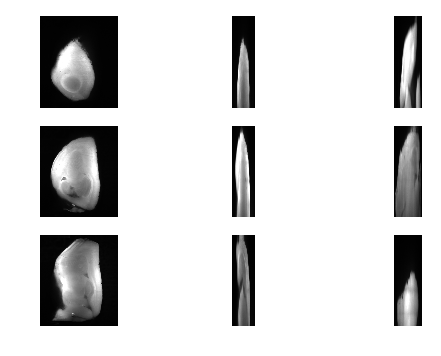

In [13]:
inThreshold = imgPercentile(inImg, 0.99)
imgShow(inImg, vmax=inThreshold)

## Reorienting input image
You may have noticed that the input brain is not oriented in the same way as the atlas.  Let's look at the atlas.

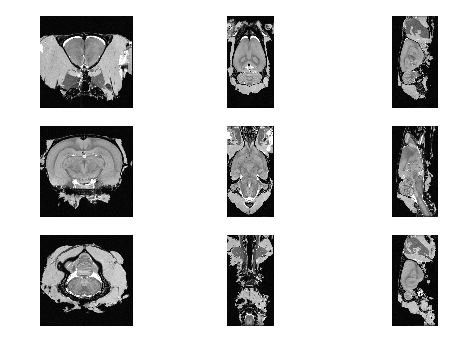

In [14]:
imgShow(refImg, vmax=refThreshold)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the input brain...

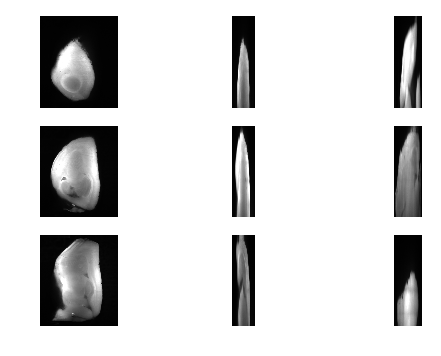

In [15]:
imgShow(inImg, vmax=inThreshold)

...we see that the x-axis goes from **I**nferior to Superior, the y-axis goes from **A**nterior to Posterior and the Z axis goes from **L**eft to Right.  Thus it's in **IAL** orientation.  Therefore we reorient the input image from **IAL** to **RSA**

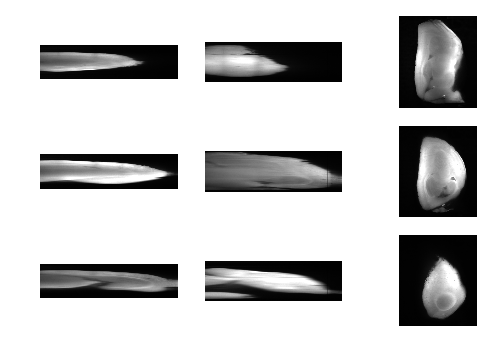

In [16]:
inOrient = "IAL"
refOrient = "RSA"
inImg = imgReorient(inImg, inOrient, refOrient)
imgShow(inImg, vmax=inThreshold)

Compare the above to the Atlas.  The slices should now correspond with the atlas.  Let's make a copy of the reorianted image size and spacing because we'll need it later.

In [17]:
inImgSize_reorient = inImg.GetSize()
inImgSpacing_reorient= inImg.GetSpacing()

## Create brain mask of reference image

Our reference image includes tissues outside the brain while our input image does not.  Therefore we need to mask out all regions of the reference image that are not part of the brain.  This can be done easily done using the reference annotations.  First we generate a mask of the brain using non-zero annotation labels.

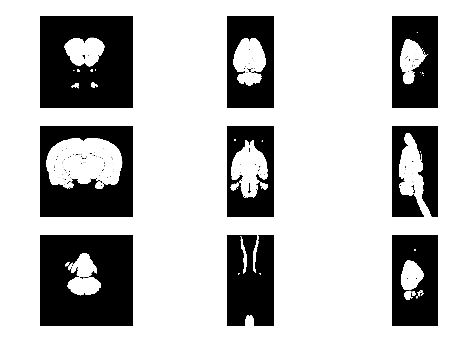

In [18]:
maskImg1 = sitk.BinaryThreshold(refAnnoImg,0,0,0,255) #lowerThreshold, UpperThreshold, insideValue, outsideValue
imgShow(maskImg1, vmax = 255)

Next we create a mask to exclude the trigeminal nerve since (Waxholm label 76) in since it's outside the brain

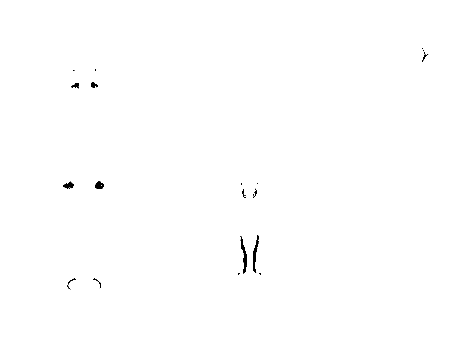

In [19]:
maskImg2 = sitk.BinaryThreshold(refAnnoImg,76,76,0,255) #lowerThreshold, UpperThreshold, insideValue, outsideValue
imgShow(maskImg2, vmax = 255)

Combining these masks

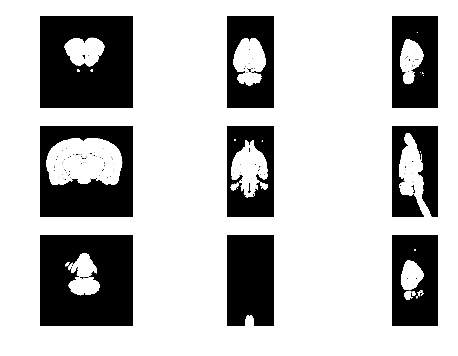

In [20]:
refMaskImg = sitk.Mask(maskImg1, maskImg2)
imgShow(refMaskImg, vmax = 255)

Now we apply the mask to the reference image.

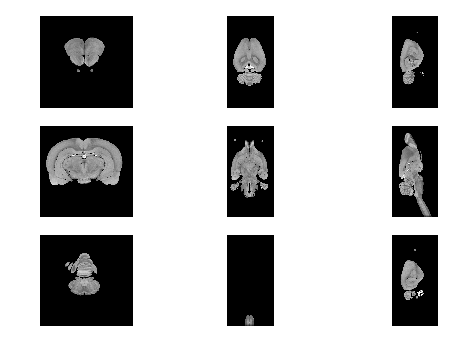

In [21]:
refImg = sitk.Mask(refImg, refMaskImg)
imgShow(refImg, vmax=refThreshold)

## Create and apply two-thirds mask of reference image
Our input image only two-thirds of a the cortex and excludes most of the cerebellum and olfactory bulb.  Therefore we need to exclude these regions from reference image annotations as well.  We do this by creating an empty image of the same size and spacing of the reference image.  We then paste an Region of Interest (ROI) from the reference mask which excludes these regions into the empty image.

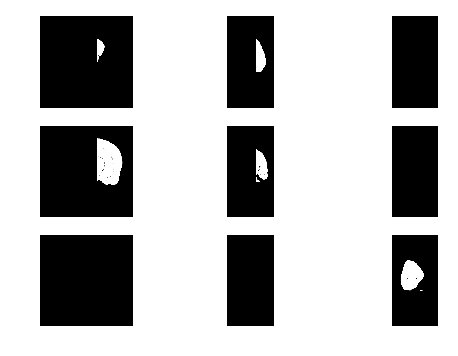

In [22]:
roiStart = [312,67,188]
roiSize = [183,296,447]

emptyImg = sitk.Image(refMaskImg.GetSize(),refMaskImg.GetPixelIDValue()) # Create an empty image
emptyImg.CopyInformation(refMaskImg) # Copy spacing, origin and direction from reference image
refMaskImg = sitk.Paste(emptyImg, refMaskImg, roiSize, roiStart, roiStart)
imgShow(refMaskImg, vmax=255)

Now we apply this mask to the reference image and annotations

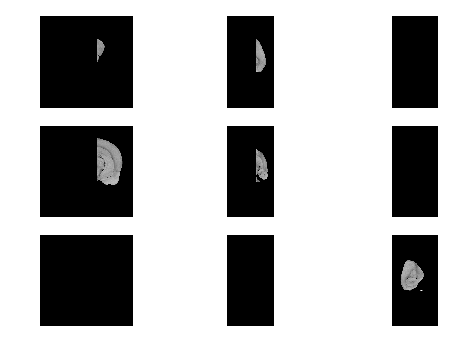

In [23]:
refImg = sitk.Mask(refImg, refMaskImg)
imgShow(refImg, vmax=refThreshold)

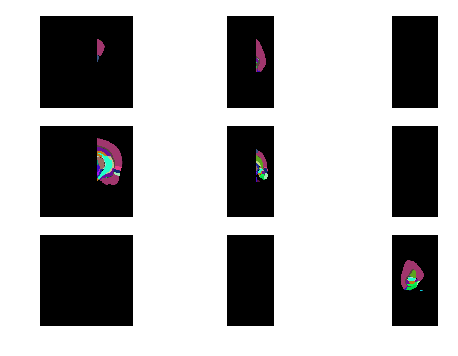

In [24]:
refAnnoImg = sitk.Mask(refAnnoImg, refMaskImg)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap)

# Affine Registration
We can finally begin the registration. Ideally we would do resgistration at the full scale but this would be far to computationally expensive for the purposes of this tutorial.  Therefore to save time we downsample the images.

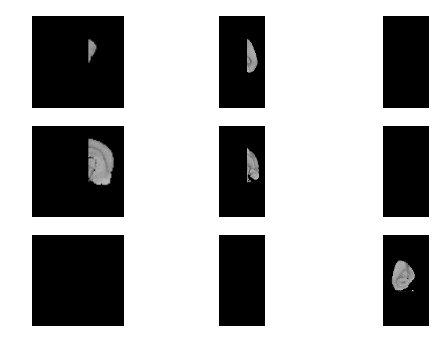

(80, 80, 160)


In [25]:
spacing=[0.25,0.25,0.25]
refImg_ds = imgResample(refImg, spacing=spacing)
imgShow(refImg_ds, vmax=refThreshold)
print(refImg_ds.GetSize())

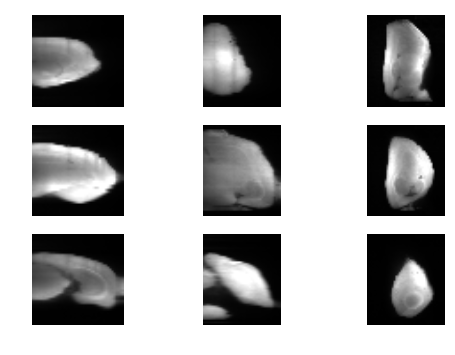

In [26]:
inImg_ds = imgResample(inImg, spacing=spacing)
imgShow(inImg_ds, vmax=inThreshold)

We will initialize the affine registration using the reference image's region of interest 

In [27]:
translation = -np.array(roiStart)*np.array(refImg.GetSpacing())
inAffine = [1.25,0,0,0,1,0,0,0,1]+translation.tolist()
print(inAffine)

[1.25, 0, 0, 0, 1, 0, 0, 0, 1, -12.168, -2.613, -7.332]


We check that our initial affine is reasonable

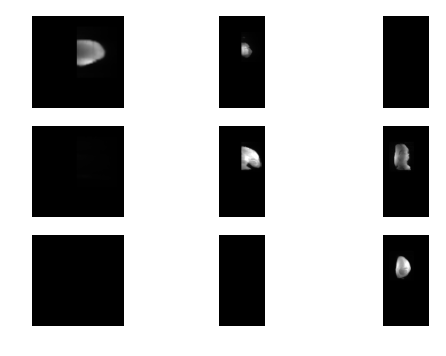

In [28]:
imgShow(imgApplyAffine(inImg_ds, inAffine, size=refImg_ds.GetSize(), spacing=refImg_ds.GetSpacing()), vmax=inThreshold)

Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the input and reference images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [29]:
affine = imgAffineComposite(inImg_ds, refImg_ds, iterations=100, useMI=True, verbose=True, inAffine=inAffine)

Step translation:
0.	 -0.103464458779
1.	 -0.107444328838
2.	 -0.107966563917
3.	 -0.111358455906
4.	 -0.111947231155
5.	 -0.115002797616
6.	 -0.118236668704
7.	 -0.12030221612
8.	 -0.123215684525
9.	 -0.126669266832
10.	 -0.126456621894
11.	 -0.129326055153
12.	 -0.12950230787
13.	 -0.131781585447
14.	 -0.134818427995
15.	 -0.134896464057
16.	 -0.137083654108
17.	 -0.14009142324
18.	 -0.139839258873
19.	 -0.141666240979
20.	 -0.144723827953
21.	 -0.14430661841
22.	 -0.144108373729
23.	 -0.146451148695
24.	 -0.146038870939
25.	 -0.147618931405
26.	 -0.149973855861
27.	 -0.149396333244
28.	 -0.150474570535
29.	 -0.152827939032
30.	 -0.15223517547
31.	 -0.153472351259
32.	 -0.156562255325
33.	 -0.156318796109
34.	 -0.157475245117
35.	 -0.158810821789
36.	 -0.162060599867
37.	 -0.162167262438
38.	 -0.163321410836
39.	 -0.167013513014
40.	 -0.167557393755
41.	 -0.169088980954
42.	 -0.169901488357
43.	 -0.171409963083
44.	 -0.171896035421
45.	 -0.172897169699
46.	 -0.171839620307
47.	 -0.17

Now we apply the affine transform to the input image and mask

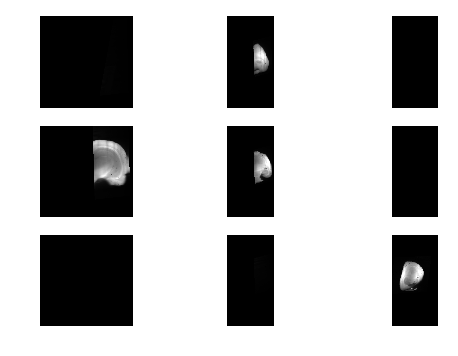

In [30]:
inImg = imgApplyAffine(inImg, affine, size=refImg.GetSize(), spacing=refImg.GetSpacing())
imgShow(inImg, vmax=inThreshold)

We can evaluate the affine registration by generating a checkerboard of the reference and input images.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

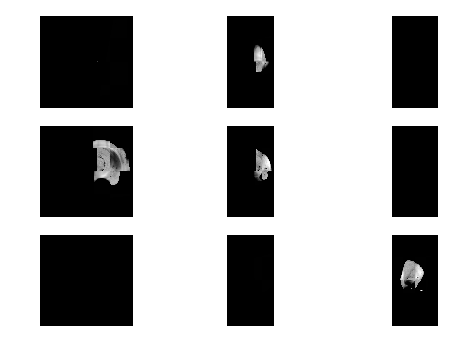

In [31]:
imgShow(imgChecker(inImg, refImg), vmax=refThreshold)

## LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [2D registration notebook](2D_Registration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input brain and reference Waxholm have very differnt intensity profiles.

In [32]:
inImg_ds = imgResample(inImg, spacing=spacing)
(field, invField) = imgMetamorphosisComposite(inImg_ds, refImg_ds, alphaList=[0.05,0.02,0.01],
                                              scaleList = [0.5,0.5,0.5], useMI=True, iterations=100, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.5
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-8.34763e+10, 4.80999, 0, -8.34763e+10 (99.0842%), 1.100000e-03
1.	-8.3823e+10, 13.0841, 0, -8.3823e+10 (98.6523%), 1.210000e-03
2.	-8.40038e+10, 23.8353, 0, -8.40038e+10 (98.427%), 1.331000e-03
3.	-8.41807e+10, 37.9026, 0, -8.41807e+10 (98.2066%), 1.464100e-03
4.	-8.44332e+10, 57.8959, 0, -8.44332e+10 (97.8922%), 1.610510e-03
5.	-8.45812e+10, 83.3511, 0, -8.45812e+10 (97.7078%), 1.771561e-03
6.	-8.47156e+10, 117.313, 0, -8.47156e+10 (97.5403%), 1.948717e-03
7.	-8.47794e+10, 161.042, 0, -8.47794e+10 (97.4609%), 2.143589e-03
8.	-8.50895e+10, 215.708, 0, -8.50895e+10 (97.0746%), 2.357948e-03
9.	-8.54271e+10, 296.925, 0, -8.54271e+10 (96.654%), 2.593742e-03
10.	-8.56986e+10, 393.314, 0, -8.56986e+10 (96.3158%), 2.853117e-03
11.	-8.59659e+10, 520.321, 0, -8.59659e+10 (95.9828%), 3.138428e-03
12.	-8.63341e+10, 678.325, 0, -8.63341e+10 (95.5241%), 3.452271e-03
13.	-8.66976e+10, 893.559, 0, 

Now we apply the displacement field

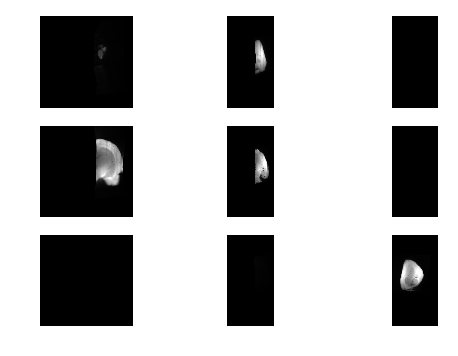

In [33]:
outImg = imgApplyField(inImg, field, size=refImg.GetSize())
imgShow(outImg, vmax=inThreshold)

### Evaluation using checker board
We can evaluate the deformable registration using a checkerboard image

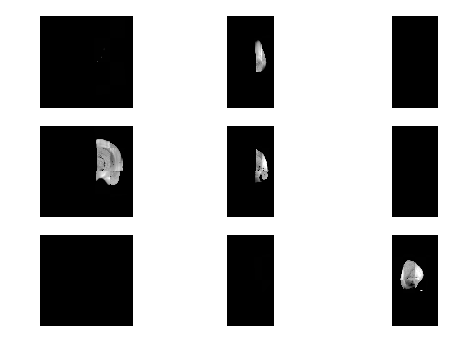

In [34]:
imgShow(imgChecker(outImg, refImg, useHM=True), vmax=refThreshold)

### Evaluation using annoatations
We can also evaluate the registration by overlaying the Waxholm annotations over the deformed input image.

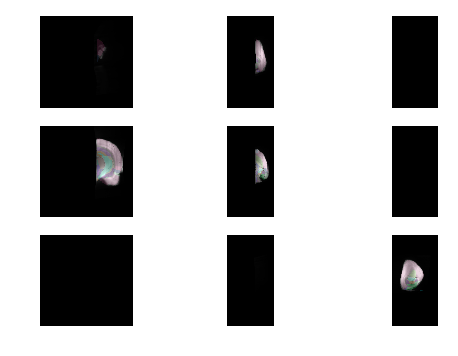

In [35]:
imgShow(outImg, vmax=inThreshold, newFig=False)
imgShow(refAnnoImg, vmax=1000, cmap=randCmap, alpha=0.2, newFig=False)
plt.show()

## Uploading Results

### Uploading deformed input image
We can now upload the Waxholm-aligned input brain back into ndstore.

In [36]:
outToken = "branch160121ToWhs2"
imgUpload(outImg, outToken, server=server, userToken=userToken)

### Visualizing deformed in put image in ndviz
We can now visulize the deformed input image on the web in *NeuroData Visualization (ndviz)*.  The function vizUrl generates a link which can be visited to examine the data.

In [38]:
tokenList = [outToken, refToken]
channelList = ["","annotation"]
url = vizUrl(tokenList, channelList, server, userToken)
print(url)

https://mri.neurodata.io/ndviz/#!{'layers':{'annotation?neariso=false':{'source':'ndstore://https://dev.neurodata.io/whs2/annotation?neariso=false'_'type':'segmentation'}_'image?neariso=false':{'source':'ndstore://https://dev.neurodata.io/branch160121ToWhs2/image?neariso=false'_'type':'image'}}_'layout':'4panel'}


### Uploading deformed atlas annotations

In [ ]:
spacing_ds = invField.GetSpacing()
size_ds = np.ceil(np.array(refAnnoImg.GetSize())*np.array(refAnnoImg.GetSpacing())/np.array(spacing_ds))
size_ds = list(size_ds.astype(int))

Before we can overlay the Waxholm annotations on the downloaded image we must transfom them to its space. Fortunatly this can be done since all spatial transforms in this tutorial are invertable.  First we construct an inverse displacement field which transforms the annotations from the Waxholm space to the space before registration.

In [ ]:
invAffine = affineInverse(affine)
invAffineField = affineToField(invAffine, size_ds, spacing_ds)
invField2 = fieldApplyField(invAffineField, invField)
inAnnoImg = imgApplyField(refAnnoImg, invField2,useNearest=True, size=inImgSize_reorient, spacing=inImgSpacing_reorient)
inAnnoThreshold = imgPercentile(inAnnoImg,0.99)
imgShow(inAnnoImg, vmax=inAnnoThreshold)

Were not done yet.  We still need to reorient these annotations to their original  

In [ ]:
inAnnoImg = imgReorient(inAnnoImg, refOrient, inOrient)
imgShow(inAnnoImg, vmax=inAnnoThreshold)

In [ ]:
imgWrite(inAnnoImg,"/cis/project/clarity/data/audrey/inAnno.img")

We can upload these annotations at the lowest possible resolution.

In [ ]:
outToken = "ara3_to_AutA"
outChannel = "annotation_draft"
imgUpload(inAnnoImg, outToken, outChannel, resolution=5)